# CNN and Transfer Learning: CIFAR-10 Classification

This notebook trains a CNN from scratch on CIFAR-10, applies transfer learning with a pre-trained ResNet-18, and compares both approaches.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import time

# Use MPS (Apple Silicon) if available, otherwise CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


## Data Loading and Preprocessing

In [2]:
# Transforms for the CNN trained from scratch
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# Split: 45,000 train / 5,000 validation
train_dataset, val_dataset = random_split(full_train_dataset, [45000, 5000])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples:   {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples:       {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Training samples:   45000
Validation samples: 5000
Test samples:       10000


## Part 1: Training a CNN from Scratch

A three-block CNN with batch normalization and dropout. Trained for 15 epochs with Adam and a step learning rate scheduler.

In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1: 3 -> 32 channels
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),

            # Block 2: 32 -> 64 channels
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),

            # Block 3: 64 -> 128 channels
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.4),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model_cnn = CNN(num_classes=10).to(device)

total_params = sum(p.numel() for p in model_cnn.parameters())
print(f"CNN total parameters: {total_params:,}")

CNN total parameters: 815,018


In [4]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, 100.0 * correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / total, 100.0 * correct / total

### Training the CNN (15 epochs)

In [5]:
CNN_EPOCHS = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

cnn_history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

print("Training CNN from scratch...")
start = time.time()

for epoch in range(CNN_EPOCHS):
    train_loss, train_acc = train_one_epoch(model_cnn, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model_cnn, val_loader, criterion)
    scheduler.step()

    cnn_history["train_loss"].append(train_loss)
    cnn_history["val_loss"].append(val_loss)
    cnn_history["train_acc"].append(train_acc)
    cnn_history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1:2d}/{CNN_EPOCHS}]  "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}%  "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.2f}%")

cnn_time = time.time() - start
print(f"\nCNN training completed in {cnn_time/60:.1f} minutes")

Training CNN from scratch...
Epoch [ 1/15]  Train Loss: 1.8394  Train Acc: 31.32%  Val Loss: 1.5279  Val Acc: 44.10%
Epoch [ 2/15]  Train Loss: 1.5820  Train Acc: 41.63%  Val Loss: 1.3268  Val Acc: 51.12%
Epoch [ 3/15]  Train Loss: 1.4435  Train Acc: 47.57%  Val Loss: 1.2038  Val Acc: 55.88%
Epoch [ 4/15]  Train Loss: 1.3366  Train Acc: 51.82%  Val Loss: 1.1401  Val Acc: 58.10%
Epoch [ 5/15]  Train Loss: 1.2545  Train Acc: 55.05%  Val Loss: 1.0331  Val Acc: 62.40%
Epoch [ 6/15]  Train Loss: 1.1796  Train Acc: 57.96%  Val Loss: 0.9992  Val Acc: 64.82%
Epoch [ 7/15]  Train Loss: 1.1294  Train Acc: 60.02%  Val Loss: 0.9114  Val Acc: 66.48%
Epoch [ 8/15]  Train Loss: 1.0855  Train Acc: 61.80%  Val Loss: 0.8722  Val Acc: 69.06%
Epoch [ 9/15]  Train Loss: 1.0510  Train Acc: 63.14%  Val Loss: 0.8324  Val Acc: 70.90%
Epoch [10/15]  Train Loss: 1.0125  Train Acc: 64.83%  Val Loss: 0.8308  Val Acc: 70.98%
Epoch [11/15]  Train Loss: 0.9436  Train Acc: 67.02%  Val Loss: 0.7534  Val Acc: 73.64%
Epo

### CNN Test Evaluation

In [6]:
cnn_test_loss, cnn_test_acc = evaluate(model_cnn, test_loader, criterion)
print(f"CNN Test Accuracy: {cnn_test_acc:.2f}%")
print(f"CNN Test Loss:     {cnn_test_loss:.4f}")

CNN Test Accuracy: 75.94%
CNN Test Loss:     0.6893


## Part 2: Transfer Learning with ResNet-18

Load a pre-trained ResNet-18 and replace the final fully connected layer to output 10 classes. All convolutional layers are frozen; only the new FC layer is trained. CIFAR-10 images are resized to 224x224 for compatibility with the pre-trained model.

In [7]:
# Transforms with resize to 224x224 for ResNet-18
transform_resnet_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_resnet_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

resnet_train_full = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=transform_resnet_train
)
resnet_test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=False, transform=transform_resnet_test
)

resnet_train_set, resnet_val_set = random_split(resnet_train_full, [45000, 5000])

# Smaller batch size because 224x224 images use more memory
resnet_train_loader = DataLoader(resnet_train_set, batch_size=32, shuffle=True, num_workers=0)
resnet_val_loader = DataLoader(resnet_val_set, batch_size=64, shuffle=False, num_workers=0)
resnet_test_loader = DataLoader(resnet_test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [8]:
# Load pre-trained ResNet-18 and freeze all layers
model_resnet = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
)

for param in model_resnet.parameters():
    param.requires_grad = False

# Replace the final FC layer (512 -> 10)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 10)
model_resnet = model_resnet.to(device)

trainable = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)
total = sum(p.numel() for p in model_resnet.parameters())
print(f"ResNet-18 trainable parameters: {trainable:,} / {total:,} total")

ResNet-18 trainable parameters: 5,130 / 11,181,642 total


### Fine-tuning ResNet-18 (5 epochs)

In [9]:
RESNET_EPOCHS = 5

resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

resnet_accs = {"train": [], "val": []}

print("Fine-tuning ResNet-18...")
start = time.time()

for epoch in range(RESNET_EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model_resnet, resnet_train_loader, resnet_criterion, resnet_optimizer
    )
    val_loss, val_acc = evaluate(model_resnet, resnet_val_loader, resnet_criterion)

    resnet_accs["train"].append(train_acc)
    resnet_accs["val"].append(val_acc)

    print(f"Epoch [{epoch+1}/{RESNET_EPOCHS}]  "
          f"Train Acc: {train_acc:.2f}%  Val Acc: {val_acc:.2f}%")

resnet_time = time.time() - start
print(f"\nResNet-18 fine-tuning completed in {resnet_time/60:.1f} minutes")
print(f"\nTotal training time: {(cnn_time + resnet_time)/60:.1f} minutes")

Fine-tuning ResNet-18...
Epoch [1/5]  Train Acc: 72.99%  Val Acc: 80.02%
Epoch [2/5]  Train Acc: 77.86%  Val Acc: 81.08%
Epoch [3/5]  Train Acc: 78.62%  Val Acc: 81.20%
Epoch [4/5]  Train Acc: 78.64%  Val Acc: 81.18%
Epoch [5/5]  Train Acc: 78.95%  Val Acc: 81.12%

ResNet-18 fine-tuning completed in 7.5 minutes

Total training time: 11.2 minutes


### ResNet-18 Test Evaluation

In [10]:
resnet_test_loss, resnet_test_acc = evaluate(
    model_resnet, resnet_test_loader, resnet_criterion
)
print(f"ResNet-18 Test Accuracy: {resnet_test_acc:.2f}%")

ResNet-18 Test Accuracy: 80.20%


## Part 3: Performance Comparison and Analysis

### CNN Training Curves (Loss and Accuracy)

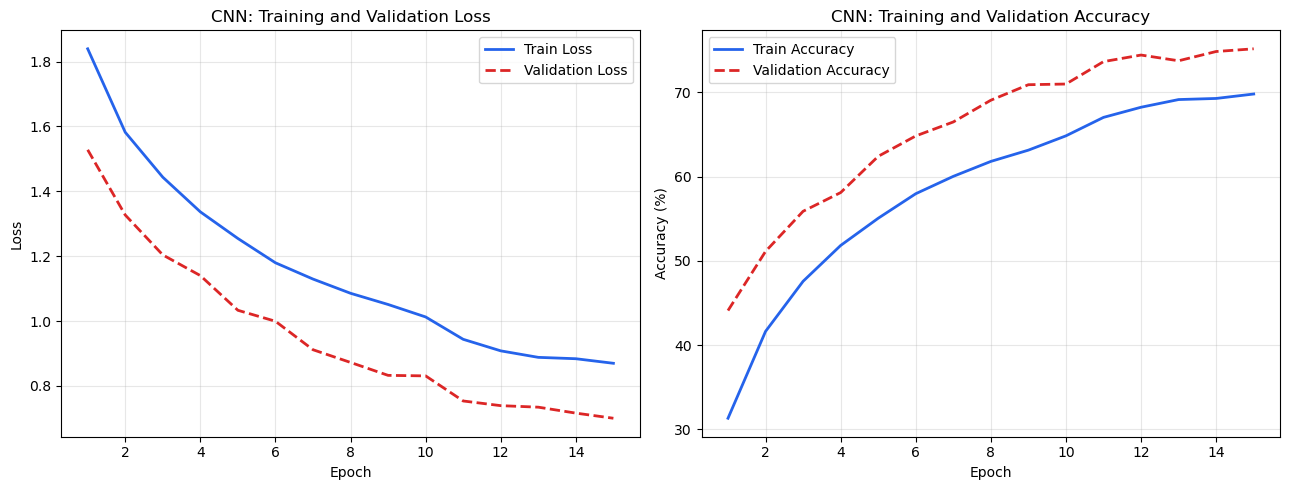

In [11]:
epochs_range = range(1, CNN_EPOCHS + 1)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Loss
axes[0].plot(epochs_range, cnn_history["train_loss"],
             label="Train Loss", color="#2563EB", linewidth=2)
axes[0].plot(epochs_range, cnn_history["val_loss"],
             label="Validation Loss", color="#DC2626", linestyle="--", linewidth=2)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("CNN: Training and Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs_range, cnn_history["train_acc"],
             label="Train Accuracy", color="#2563EB", linewidth=2)
axes[1].plot(epochs_range, cnn_history["val_acc"],
             label="Validation Accuracy", color="#DC2626", linestyle="--", linewidth=2)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("CNN: Training and Validation Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("cnn_training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

### ResNet-18 Accuracy

In [12]:
print(f"ResNet-18 Final Test Accuracy: {resnet_test_acc:.2f}%")

ResNet-18 Final Test Accuracy: 80.20%


### Final Comparison

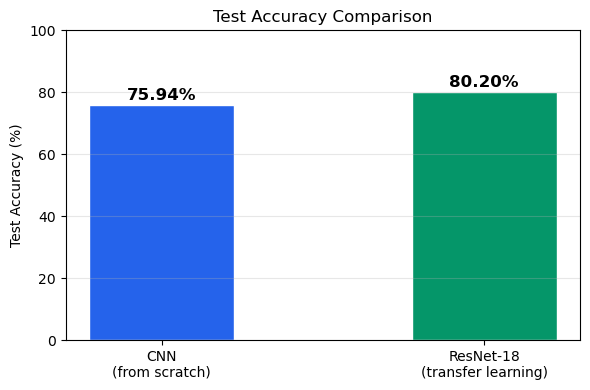

CNN Test Accuracy:       75.94%
ResNet-18 Test Accuracy: 80.20%


In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

models = ["CNN\n(from scratch)", "ResNet-18\n(transfer learning)"]
accuracies = [cnn_test_acc, resnet_test_acc]
colors = ["#2563EB", "#059669"]

bars = ax.bar(models, accuracies, color=colors, width=0.45, edgecolor="white")

for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
            f"{acc:.2f}%", ha="center", va="bottom", fontweight="bold", fontsize=12)

ax.set_ylabel("Test Accuracy (%)")
ax.set_title("Test Accuracy Comparison")
ax.set_ylim(0, 100)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"CNN Test Accuracy:       {cnn_test_acc:.2f}%")
print(f"ResNet-18 Test Accuracy: {resnet_test_acc:.2f}%")